<a href="https://colab.research.google.com/github/priyasha2011/quantum/blob/main/purequantumVQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CELL 1: Install Dependencies (after restart)
!pip install pennylane torch torchvision pillow captcha numpy matplotlib -q
print("✅ Installation complete!")

✅ Installation complete!


In [ ]:
import os
import random
from captcha.image import ImageCaptcha
from tqdm import tqdm

CHAR_SET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
MIN_LENGTH, MAX_LENGTH = 4, 6
IMG_WIDTH, IMG_HEIGHT = 180, 60
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 2000, 500, 500

BASE_DIR = "/content/captcha_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

for path in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(path, exist_ok=True)

def random_captcha_text(min_len=MIN_LENGTH, max_len=MAX_LENGTH):
    length = random.randint(min_len, max_len)
    return ''.join(random.choices(CHAR_SET, k=length))

def generate_dataset(split_dir, num_samples):
    image_captcha = ImageCaptcha(width=IMG_WIDTH, height=IMG_HEIGHT)
    for _ in tqdm(range(num_samples), desc=f"Generating {split_dir.split('/')[-1]}"):
        text = random_captcha_text()
        image = image_captcha.generate_image(text).convert("RGB")
        file_path = os.path.join(split_dir, f"{text}.png")
        image.save(file_path)

generate_dataset(TRAIN_DIR, TRAIN_SIZE)
generate_dataset(VAL_DIR, VAL_SIZE)
generate_dataset(TEST_DIR, TEST_SIZE)

print("✅ Dataset generation complete!")

Generating test: 100%|██████████| 500/500 [00:03<00:00, 162.25it/s]

✅ Dataset generation complete!


In [ ]:
import os
from PIL import Image
from tqdm import tqdm

BASE_DIR = "/content/captcha_dataset"
SPLITS = ["train", "val", "test"]
OUT_SUBDIR = "chars_8x8"

for split in SPLITS:
    split_dir = os.path.join(BASE_DIR, split)
    out_dir = os.path.join(split_dir, OUT_SUBDIR)
    os.makedirs(out_dir, exist_ok=True)

    for fname in tqdm(sorted(os.listdir(split_dir)), desc=f"Segment {split}"):
        if not fname.lower().endswith(".png"):
            continue

        text = fname[:-4]  # drop .png
        img = Image.open(os.path.join(split_dir, fname)).convert("L")
        W, H = img.size
        n = len(text)
        slice_w = W / n

        for i, ch in enumerate(text):
            left = int(round(i * slice_w))
            right = int(round((i + 1) * slice_w))
            crop = img.crop((left, 0, right, H))
            crop = crop.resize((8, 8), Image.BILINEAR)
            save_name = f"{text}_{i}_{ch}.png"
            crop.save(os.path.join(out_dir, save_name))

print("✅ Character segmentation complete!")

Segment test: 100%|██████████| 501/501 [00:01<00:00, 294.69it/s]

✅ Character segmentation complete!


In [ ]:
%%writefile dataset_chars_fixed.py

import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np

CHAR_SET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

class CaptchaCharDataset(Dataset):
    """Load pre-segmented 8x8 character images from chars_8x8 subdirectory"""
    def __init__(self, root_dir, img_size=8):
        self.samples = []
        self.img_size = img_size

        # Look in the chars_8x8 subdirectory for segmented characters
        chars_dir = os.path.join(root_dir, "chars_8x8")
        if not os.path.exists(chars_dir):
            raise ValueError(f"Segmented chars directory not found: {chars_dir}")

        for fname in os.listdir(chars_dir):
            if fname.endswith('.png'):
                # Filename format: CAPTCHA_TEXT_position_character.png
                # Example: ABC123_0_A.png
                parts = fname[:-4].split('_')
                if len(parts) >= 3:
                    char_label = parts[-1]  # Last part is the character
                    if char_label in CHAR_SET:
                        self.samples.append((os.path.join(chars_dir, fname), char_label))

        self.char_to_idx = {ch: i for i, ch in enumerate(CHAR_SET)}
        print(f"Loaded {len(self.samples)} character samples from {chars_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label_char = self.samples[idx]

        # Load the already-segmented 8x8 character image
        img = Image.open(img_path).convert('L')
        img = img.resize((self.img_size, self.img_size), Image.BILINEAR)

        # Normalize to [0, 1]
        x = np.array(img).flatten() / 255.0
        y = self.char_to_idx[label_char]

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

Overwriting dataset_chars_fixed.py


Loaded 10044 character samples from /content/captcha_dataset/train/chars_8x8
Number of training samples: 10044


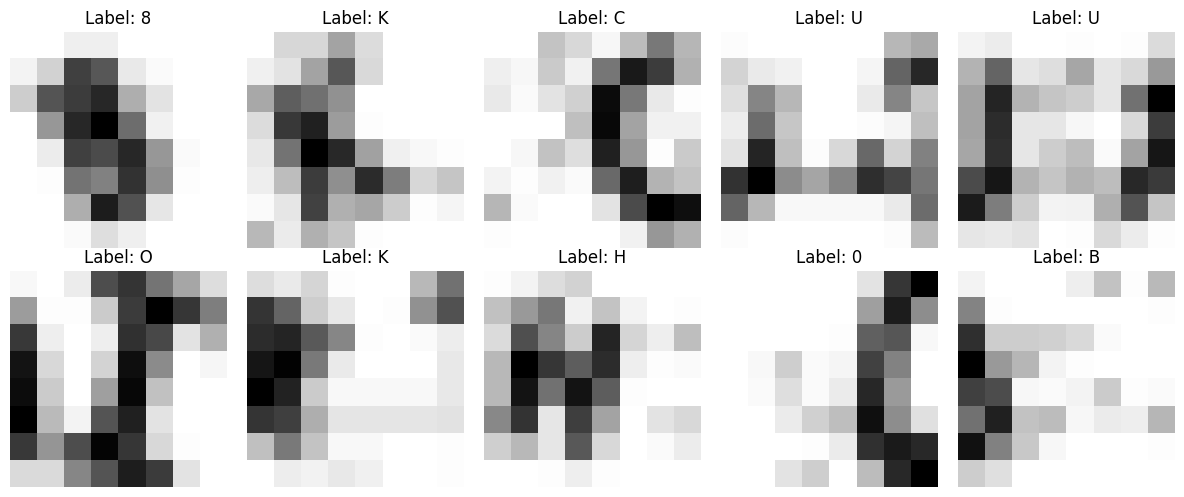

In [ ]:
import matplotlib.pyplot as plt
from dataset_chars_fixed import CaptchaCharDataset, CHAR_SET

# Load dataset
train_dataset = CaptchaCharDataset("/content/captcha_dataset/train")
print(f"Number of training samples: {len(train_dataset)}")

# View random samples
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    x, y = train_dataset[i * 100]  # Sample every 100th image
    ax.imshow(x.reshape(8, 8), cmap='gray')
    ax.set_title(f"Label: {CHAR_SET[y]}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# CELL 6 (FIXED): Define quantum models with proper dtype handling
%%writefile quantum_vqc_model.py

import pennylane as qml
import torch
import torch.nn as nn

CHAR_SET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

class FullyQuantumVQC(nn.Module):
    def __init__(self, n_qubits=6, n_layers=3, n_classes=len(CHAR_SET)):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.n_classes = n_classes

        self.dev = qml.device("default.qubit", wires=n_qubits)

        @qml.qnode(self.dev, interface="torch", diff_method="backprop")
        def quantum_circuit(inputs, weights):
            for layer in range(n_layers):
                qml.AmplitudeEmbedding(inputs, wires=range(n_qubits),
                                      pad_with=0.0, normalize=True)

                for i in range(n_qubits):
                    qml.RY(weights[layer, i, 0], wires=i)
                    qml.RZ(weights[layer, i, 1], wires=i)

                for i in range(n_qubits - 1):
                    qml.CNOT(wires=[i, i + 1])
                qml.CNOT(wires=[n_qubits - 1, 0])

            measurements = []
            for i in range(n_qubits):
                measurements.append(qml.expval(qml.PauliZ(i)))

            for i in range(n_qubits - 1):
                measurements.append(qml.expval(qml.PauliZ(i) @ qml.PauliZ(i + 1)))

            for i in range(n_qubits - 2):
                measurements.append(qml.expval(qml.PauliZ(i) @ qml.PauliZ(i + 1) @ qml.PauliZ(i + 2)))

            return measurements

        self.circuit = quantum_circuit
        self.q_weights = nn.Parameter(torch.randn(n_layers, n_qubits, 2) * 0.1)

        n_measurements = n_qubits + (n_qubits - 1) + (n_qubits - 2)
        self.output_layer = nn.Linear(n_measurements, n_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        quantum_features = []

        for i in range(batch_size):
            measurements = self.circuit(x[i], self.q_weights)

            # Convert to tensor and ensure correct dtype
            if isinstance(measurements, (list, tuple)):
                measurements = torch.tensor([float(m) for m in measurements],
                                           dtype=torch.float32, device=x.device)
            else:
                measurements = measurements.float()

            quantum_features.append(measurements)

        quantum_features = torch.stack(quantum_features)
        logits = self.output_layer(quantum_features)

        return logits


class OptimizedQuantumVQC(nn.Module):
    def __init__(self, n_qubits=6, n_layers=2, n_classes=len(CHAR_SET)):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.n_classes = n_classes

        self.dev = qml.device("default.qubit", wires=n_qubits)

        @qml.qnode(self.dev, interface="torch", diff_method="backprop")
        def circuit(inputs, weights):
            qml.AmplitudeEmbedding(inputs, wires=range(n_qubits),
                                  pad_with=0.0, normalize=True)

            for layer in range(n_layers):
                for i in range(n_qubits):
                    qml.RY(weights[layer, i, 0], wires=i)
                    qml.RZ(weights[layer, i, 1], wires=i)

                for i in range(0, n_qubits - 1, 2):
                    qml.CNOT(wires=[i, i + 1])
                for i in range(1, n_qubits - 1, 2):
                    qml.CNOT(wires=[i, i + 1])

            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        self.circuit = circuit
        self.q_weights = nn.Parameter(torch.randn(n_layers, n_qubits, 2) * 0.1)

        self.readout = nn.Sequential(
            nn.Linear(n_qubits, n_qubits * 2),
            nn.Tanh(),
            nn.Linear(n_qubits * 2, n_classes)
        )

    def forward(self, x):
        batch_outputs = []

        for xi in x:
            out = self.circuit(xi, self.q_weights)

            # Convert to tensor and ensure correct dtype
            if isinstance(out, (list, tuple)):
                out = torch.tensor([float(o) for o in out],
                                  dtype=torch.float32, device=x.device)
            else:
                out = out.float()

            batch_outputs.append(out)

        quantum_features = torch.stack(batch_outputs)
        return self.readout(quantum_features)

Writing quantum_vqc_model.py


In [ ]:
# CELL 7: Import and verify
from quantum_vqc_model import FullyQuantumVQC, OptimizedQuantumVQC
import torch

print("✅ Models imported successfully!")

# Quick test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model = OptimizedQuantumVQC(n_qubits=6, n_layers=2).to(device)
test_input = torch.randn(2, 64).to(device)
test_output = test_model(test_input)
print(f"Test passed! Output shape: {test_output.shape}")
print(f"Output dtype: {test_output.dtype}")

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


✅ Models imported successfully!
Test passed! Output shape: torch.Size([2, 36])
Output dtype: torch.float32


/content/quantum_vqc_model.py:114: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  out = torch.tensor([float(o) for o in out],


In [ ]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

def train_quantum_model(model, train_loader, val_loader, device, epochs=50, lr=0.005, model_name="Quantum VQC"):
    """Training loop optimized for quantum models"""
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'lr': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        pbar = tqdm(train_loader, desc=f"[{model_name}] Epoch {epoch+1}/{epochs}")
        for batch_idx, (x, y) in enumerate(pbar):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            preds = logits.argmax(dim=1)
            train_correct += (preds == y).sum().item()
            train_total += y.size(0)

            # Update progress bar
            current_acc = 100 * train_correct / train_total
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{current_acc:.2f}%',
                'lr': f'{scheduler.get_last_lr()[0]:.6f}'
            })

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        val_loss = 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = F.cross_entropy(logits, y)
                val_loss += loss.item()

                preds = logits.argmax(dim=1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['lr'].append(scheduler.get_last_lr()[0])

        print(f"\n[{model_name}] Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"  LR: {scheduler.get_last_lr()[0]:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'history': history
            }, f'best_{model_name.lower().replace(" ", "_")}.pt')
            print(f"  ✅ New best model saved! Val Acc: {val_acc:.2f}%")

        scheduler.step()
        print("-" * 60)

    return history

In [ ]:
# CELL 8: Prepare Data Loaders
import torch
from torch.utils.data import DataLoader
from dataset_chars_fixed import CaptchaCharDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load datasets
train_dataset = CaptchaCharDataset("/content/captcha_dataset/train")
val_dataset = CaptchaCharDataset("/content/captcha_dataset/val")

# Create data loaders with smaller batch size for quantum processing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=2)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Total training samples: {len(train_dataset)}")
print(f"Total validation samples: {len(val_dataset)}")

Using device: cuda
Loaded 10044 character samples from /content/captcha_dataset/train/chars_8x8
Loaded 2494 character samples from /content/captcha_dataset/val/chars_8x8
Training batches: 628
Validation batches: 156
Total training samples: 10044
Total validation samples: 2494


In [ ]:
# CELL 9: Train Optimized Quantum Model (Start with faster version)
from quantum_vqc_model import OptimizedQuantumVQC
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

def train_quantum_model(model, train_loader, val_loader, device, epochs=30, lr=0.005, model_name="Quantum VQC"):
    """Training loop optimized for quantum models"""
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'lr': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        pbar = tqdm(train_loader, desc=f"[{model_name}] Epoch {epoch+1}/{epochs}")
        for batch_idx, (x, y) in enumerate(pbar):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()

            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item()
            preds = logits.argmax(dim=1)
            train_correct += (preds == y).sum().item()
            train_total += y.size(0)

            current_acc = 100 * train_correct / train_total
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{current_acc:.2f}%',
                'lr': f'{scheduler.get_last_lr()[0]:.6f}'
            })

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        val_loss = 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = F.cross_entropy(logits, y)
                val_loss += loss.item()

                preds = logits.argmax(dim=1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['lr'].append(scheduler.get_last_lr()[0])

        print(f"\n[{model_name}] Epoch {epoch+1}/{epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"  LR: {scheduler.get_last_lr()[0]:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'history': history
            }, f'best_{model_name.lower().replace(" ", "_")}.pt')
            print(f"  ✅ New best model saved! Val Acc: {val_acc:.2f}%")

        scheduler.step()
        print("-" * 60)

    return history


print("\n" + "="*70)
print("TRAINING OPTIMIZED QUANTUM VQC MODEL (2 LAYERS - FASTER)")
print("="*70 + "\n")

print("Model Configuration:")
print("  - 6 qubits (64 amplitude encoding)")
print("  - 2 layers (lighter circuit)")
print("  - Standard PauliZ measurements")
print("  - Small classical readout\n")

quantum_model_optimized = OptimizedQuantumVQC(n_qubits=6, n_layers=2)
total_params = sum(p.numel() for p in quantum_model_optimized.parameters())
quantum_params = quantum_model_optimized.q_weights.numel()
print(f"Total parameters: {total_params}")
print(f"Quantum parameters: {quantum_params}")
print(f"Classical parameters: {total_params - quantum_params}\n")

# Start with fewer epochs for testing
q_history_optimized = train_quantum_model(
    quantum_model_optimized,
    train_loader,
    val_loader,
    device,
    epochs=30,  # Start with 30 epochs
    lr=0.005,
    model_name="Quantum VQC Optimized"
)

print("\n✅ Optimized quantum model training complete!")
print(f"Best validation accuracy: {max(q_history_optimized['val_acc']):.2f}%")


TRAINING OPTIMIZED QUANTUM VQC MODEL (2 LAYERS - FASTER)

Model Configuration:
  - 6 qubits (64 amplitude encoding)
  - 2 layers (lighter circuit)
  - Standard PauliZ measurements
  - Small classical readout

Total parameters: 576
Quantum parameters: 24
Classical parameters: 552



[Quantum VQC Optimized] Epoch 1/30: 100%|██████████| 628/628 [03:41<00:00,  2.84it/s, loss=3.5117, acc=3.83%, lr=0.005000]



[Quantum VQC Optimized] Epoch 1/30:
  Train Loss: 3.5742 | Train Acc: 3.83%
  Val Loss: 3.5213 | Val Acc: 5.97%
  LR: 0.005000
  ✅ New best model saved! Val Acc: 5.97%
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 2/30: 100%|██████████| 628/628 [03:41<00:00,  2.83it/s, loss=3.3207, acc=6.50%, lr=0.004986]



[Quantum VQC Optimized] Epoch 2/30:
  Train Loss: 3.4688 | Train Acc: 6.50%
  Val Loss: 3.4215 | Val Acc: 6.54%
  LR: 0.004986
  ✅ New best model saved! Val Acc: 6.54%
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 3/30: 100%|██████████| 628/628 [03:41<00:00,  2.83it/s, loss=3.4148, acc=7.89%, lr=0.004945]



[Quantum VQC Optimized] Epoch 3/30:
  Train Loss: 3.4147 | Train Acc: 7.89%
  Val Loss: 3.3989 | Val Acc: 7.78%
  LR: 0.004945
  ✅ New best model saved! Val Acc: 7.78%
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 4/30: 100%|██████████| 628/628 [03:39<00:00,  2.86it/s, loss=3.3630, acc=8.84%, lr=0.004878]



[Quantum VQC Optimized] Epoch 4/30:
  Train Loss: 3.3969 | Train Acc: 8.84%
  Val Loss: 3.3878 | Val Acc: 7.82%
  LR: 0.004878
  ✅ New best model saved! Val Acc: 7.82%
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 5/30: 100%|██████████| 628/628 [03:36<00:00,  2.91it/s, loss=3.4726, acc=8.91%, lr=0.004784]



[Quantum VQC Optimized] Epoch 5/30:
  Train Loss: 3.3843 | Train Acc: 8.91%
  Val Loss: 3.3688 | Val Acc: 8.74%
  LR: 0.004784
  ✅ New best model saved! Val Acc: 8.74%
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 6/30: 100%|██████████| 628/628 [03:35<00:00,  2.92it/s, loss=3.1693, acc=9.60%, lr=0.004666]



[Quantum VQC Optimized] Epoch 6/30:
  Train Loss: 3.3761 | Train Acc: 9.60%
  Val Loss: 3.3646 | Val Acc: 8.42%
  LR: 0.004666
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 7/30: 100%|██████████| 628/628 [03:32<00:00,  2.95it/s, loss=2.9523, acc=9.47%, lr=0.004523]



[Quantum VQC Optimized] Epoch 7/30:
  Train Loss: 3.3730 | Train Acc: 9.47%
  Val Loss: 3.3676 | Val Acc: 8.26%
  LR: 0.004523
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 8/30: 100%|██████████| 628/628 [03:32<00:00,  2.95it/s, loss=3.5460, acc=9.43%, lr=0.004359]



[Quantum VQC Optimized] Epoch 8/30:
  Train Loss: 3.3695 | Train Acc: 9.43%
  Val Loss: 3.3678 | Val Acc: 8.46%
  LR: 0.004359
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 9/30: 100%|██████████| 628/628 [03:31<00:00,  2.97it/s, loss=3.6302, acc=9.34%, lr=0.004174]



[Quantum VQC Optimized] Epoch 9/30:
  Train Loss: 3.3678 | Train Acc: 9.34%
  Val Loss: 3.3613 | Val Acc: 9.10%
  LR: 0.004174
  ✅ New best model saved! Val Acc: 9.10%
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 10/30: 100%|██████████| 628/628 [03:32<00:00,  2.96it/s, loss=3.1979, acc=9.77%, lr=0.003972]



[Quantum VQC Optimized] Epoch 10/30:
  Train Loss: 3.3688 | Train Acc: 9.77%
  Val Loss: 3.3598 | Val Acc: 9.58%
  LR: 0.003972
  ✅ New best model saved! Val Acc: 9.58%
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 11/30: 100%|██████████| 628/628 [03:31<00:00,  2.97it/s, loss=3.6593, acc=9.93%, lr=0.003753]



[Quantum VQC Optimized] Epoch 11/30:
  Train Loss: 3.3671 | Train Acc: 9.93%
  Val Loss: 3.3585 | Val Acc: 9.34%
  LR: 0.003753
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 12/30: 100%|██████████| 628/628 [03:29<00:00,  3.00it/s, loss=3.5955, acc=9.53%, lr=0.003520]



[Quantum VQC Optimized] Epoch 12/30:
  Train Loss: 3.3666 | Train Acc: 9.53%
  Val Loss: 3.3592 | Val Acc: 9.74%
  LR: 0.003520
  ✅ New best model saved! Val Acc: 9.74%
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 13/30: 100%|██████████| 628/628 [03:30<00:00,  2.98it/s, loss=3.3990, acc=9.67%, lr=0.003276]



[Quantum VQC Optimized] Epoch 13/30:
  Train Loss: 3.3658 | Train Acc: 9.67%
  Val Loss: 3.3593 | Val Acc: 8.90%
  LR: 0.003276
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 14/30: 100%|██████████| 628/628 [03:30<00:00,  2.99it/s, loss=3.4524, acc=9.67%, lr=0.003024]



[Quantum VQC Optimized] Epoch 14/30:
  Train Loss: 3.3654 | Train Acc: 9.67%
  Val Loss: 3.3571 | Val Acc: 9.46%
  LR: 0.003024
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 15/30: 100%|██████████| 628/628 [03:29<00:00,  3.00it/s, loss=3.3519, acc=9.94%, lr=0.002766]



[Quantum VQC Optimized] Epoch 15/30:
  Train Loss: 3.3638 | Train Acc: 9.94%
  Val Loss: 3.3618 | Val Acc: 9.58%
  LR: 0.002766
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 16/30: 100%|██████████| 628/628 [03:31<00:00,  2.97it/s, loss=3.3517, acc=9.64%, lr=0.002505]



[Quantum VQC Optimized] Epoch 16/30:
  Train Loss: 3.3632 | Train Acc: 9.64%
  Val Loss: 3.3587 | Val Acc: 8.54%
  LR: 0.002505
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 17/30: 100%|██████████| 628/628 [03:31<00:00,  2.97it/s, loss=3.8072, acc=10.12%, lr=0.002244]



[Quantum VQC Optimized] Epoch 17/30:
  Train Loss: 3.3632 | Train Acc: 10.12%
  Val Loss: 3.3601 | Val Acc: 9.02%
  LR: 0.002244
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 18/30: 100%|██████████| 628/628 [03:31<00:00,  2.97it/s, loss=3.2692, acc=9.84%, lr=0.001986]



[Quantum VQC Optimized] Epoch 18/30:
  Train Loss: 3.3614 | Train Acc: 9.84%
  Val Loss: 3.3605 | Val Acc: 8.82%
  LR: 0.001986
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 19/30: 100%|██████████| 628/628 [03:28<00:00,  3.01it/s, loss=3.3800, acc=10.01%, lr=0.001734]



[Quantum VQC Optimized] Epoch 19/30:
  Train Loss: 3.3610 | Train Acc: 10.01%
  Val Loss: 3.3599 | Val Acc: 9.22%
  LR: 0.001734
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 20/30: 100%|██████████| 628/628 [03:28<00:00,  3.01it/s, loss=3.4601, acc=10.01%, lr=0.001490]



[Quantum VQC Optimized] Epoch 20/30:
  Train Loss: 3.3610 | Train Acc: 10.01%
  Val Loss: 3.3576 | Val Acc: 9.34%
  LR: 0.001490
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 21/30: 100%|██████████| 628/628 [03:28<00:00,  3.01it/s, loss=3.3214, acc=10.12%, lr=0.001258]



[Quantum VQC Optimized] Epoch 21/30:
  Train Loss: 3.3599 | Train Acc: 10.12%
  Val Loss: 3.3584 | Val Acc: 9.50%
  LR: 0.001258
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 22/30: 100%|██████████| 628/628 [03:28<00:00,  3.01it/s, loss=3.2734, acc=10.20%, lr=0.001038]



[Quantum VQC Optimized] Epoch 22/30:
  Train Loss: 3.3591 | Train Acc: 10.20%
  Val Loss: 3.3580 | Val Acc: 9.82%
  LR: 0.001038
  ✅ New best model saved! Val Acc: 9.82%
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 23/30: 100%|██████████| 628/628 [03:28<00:00,  3.00it/s, loss=3.2081, acc=10.14%, lr=0.000836]



[Quantum VQC Optimized] Epoch 23/30:
  Train Loss: 3.3588 | Train Acc: 10.14%
  Val Loss: 3.3576 | Val Acc: 9.58%
  LR: 0.000836
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 24/30: 100%|██████████| 628/628 [03:28<00:00,  3.01it/s, loss=2.9468, acc=10.05%, lr=0.000651]



[Quantum VQC Optimized] Epoch 24/30:
  Train Loss: 3.3582 | Train Acc: 10.05%
  Val Loss: 3.3578 | Val Acc: 9.82%
  LR: 0.000651
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 25/30: 100%|██████████| 628/628 [03:29<00:00,  2.99it/s, loss=3.6322, acc=10.20%, lr=0.000487]



[Quantum VQC Optimized] Epoch 25/30:
  Train Loss: 3.3579 | Train Acc: 10.20%
  Val Loss: 3.3569 | Val Acc: 9.50%
  LR: 0.000487
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 26/30: 100%|██████████| 628/628 [03:28<00:00,  3.01it/s, loss=3.3906, acc=10.22%, lr=0.000344]



[Quantum VQC Optimized] Epoch 26/30:
  Train Loss: 3.3575 | Train Acc: 10.22%
  Val Loss: 3.3569 | Val Acc: 9.58%
  LR: 0.000344
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 27/30: 100%|██████████| 628/628 [03:29<00:00,  3.00it/s, loss=3.5146, acc=10.22%, lr=0.000226]



[Quantum VQC Optimized] Epoch 27/30:
  Train Loss: 3.3571 | Train Acc: 10.22%
  Val Loss: 3.3572 | Val Acc: 9.54%
  LR: 0.000226
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 28/30: 100%|██████████| 628/628 [03:31<00:00,  2.97it/s, loss=3.5348, acc=10.27%, lr=0.000132]



[Quantum VQC Optimized] Epoch 28/30:
  Train Loss: 3.3569 | Train Acc: 10.27%
  Val Loss: 3.3570 | Val Acc: 9.70%
  LR: 0.000132
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 29/30: 100%|██████████| 628/628 [03:34<00:00,  2.93it/s, loss=3.1725, acc=10.22%, lr=0.000065]



[Quantum VQC Optimized] Epoch 29/30:
  Train Loss: 3.3565 | Train Acc: 10.22%
  Val Loss: 3.3571 | Val Acc: 9.66%
  LR: 0.000065
------------------------------------------------------------


[Quantum VQC Optimized] Epoch 30/30: 100%|██████████| 628/628 [03:33<00:00,  2.94it/s, loss=3.1606, acc=10.24%, lr=0.000024]



[Quantum VQC Optimized] Epoch 30/30:
  Train Loss: 3.3564 | Train Acc: 10.24%
  Val Loss: 3.3571 | Val Acc: 9.62%
  LR: 0.000024
------------------------------------------------------------

✅ Optimized quantum model training complete!
Best validation accuracy: 9.82%


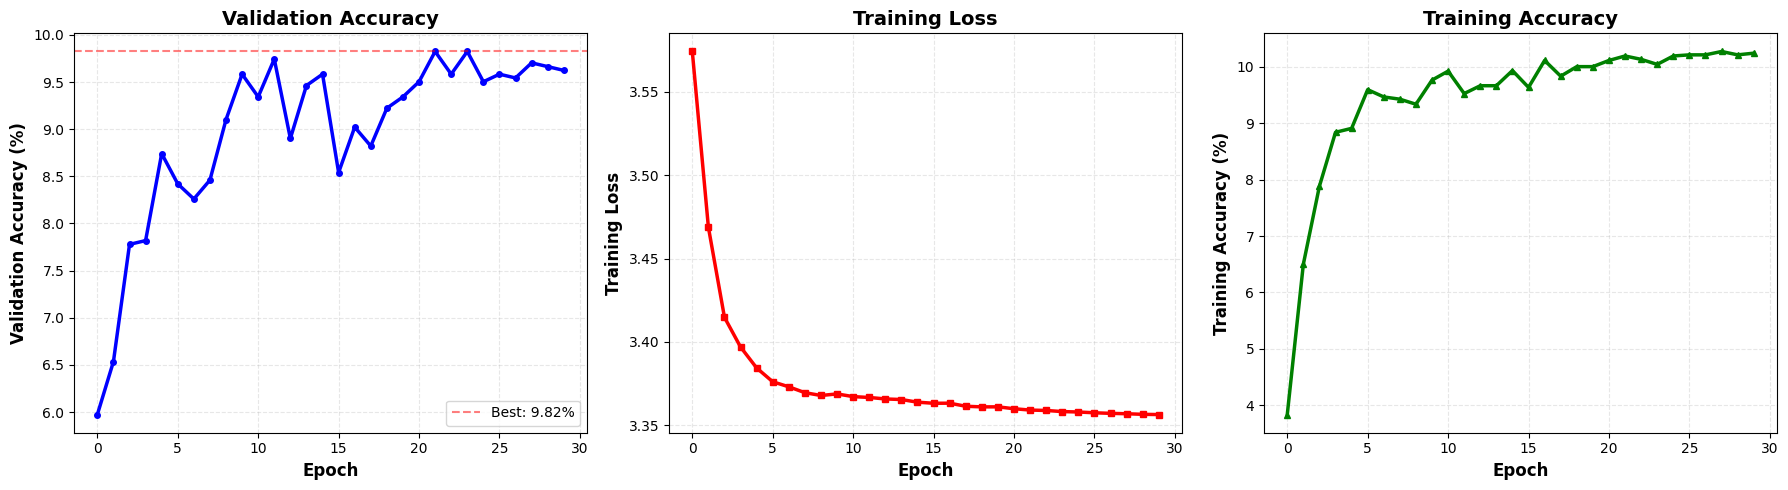


TRAINING SUMMARY
Best Val Acc: 9.82%
Final Train Acc: 10.24%
Final Loss: 3.3564


In [ ]:
# CELL 10: Visualize Training Progress
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Validation Accuracy
axes[0].plot(q_history_optimized['val_acc'], 'b-', linewidth=2.5, marker='o', markersize=4)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Validation Accuracy (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].axhline(y=max(q_history_optimized['val_acc']), color='r', linestyle='--', alpha=0.5, label=f'Best: {max(q_history_optimized["val_acc"]):.2f}%')
axes[0].legend()

# Plot 2: Training Loss
axes[1].plot(q_history_optimized['train_loss'], 'r-', linewidth=2.5, marker='s', markersize=4)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Training Loss', fontsize=12, fontweight='bold')
axes[1].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--')

# Plot 3: Training Accuracy
axes[2].plot(q_history_optimized['train_acc'], 'g-', linewidth=2.5, marker='^', markersize=4)
axes[2].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Training Accuracy (%)', fontsize=12, fontweight='bold')
axes[2].set_title('Training Accuracy', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('quantum_training_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"Best Val Acc: {max(q_history_optimized['val_acc']):.2f}%")
print(f"Final Train Acc: {q_history_optimized['train_acc'][-1]:.2f}%")
print(f"Final Loss: {q_history_optimized['train_loss'][-1]:.4f}")
print("="*70)

In [ ]:
# CELL 11 (OPTIONAL): Train Advanced Model with More Layers
# Only run this if you want to try the more complex model

from quantum_vqc_model import FullyQuantumVQC

print("\n" + "="*70)
print("TRAINING ADVANCED QUANTUM VQC MODEL (3 LAYERS - MORE EXPRESSIVE)")
print("="*70 + "\n")

quantum_model_advanced = FullyQuantumVQC(n_qubits=6, n_layers=3)

q_history_advanced = train_quantum_model(
    quantum_model_advanced,
    train_loader,
    val_loader,
    device,
    epochs=30,
    lr=0.005,
    model_name="Quantum VQC Advanced"
)

print("\n✅ Advanced quantum model training complete!")
print(f"Best validation accuracy: {max(q_history_advanced['val_acc']):.2f}%")


TRAINING ADVANCED QUANTUM VQC MODEL (3 LAYERS - MORE EXPRESSIVE)



[Quantum VQC Advanced] Epoch 1/30: 100%|██████████| 628/628 [29:46<00:00,  2.84s/it, loss=3.5690, acc=4.39%, lr=0.005000]



[Quantum VQC Advanced] Epoch 1/30:
  Train Loss: 3.5711 | Train Acc: 4.39%
  Val Loss: 3.5536 | Val Acc: 5.37%
  LR: 0.005000
  ✅ New best model saved! Val Acc: 5.37%
------------------------------------------------------------


[Quantum VQC Advanced] Epoch 2/30: 100%|██████████| 628/628 [29:43<00:00,  2.84s/it, loss=3.5565, acc=6.18%, lr=0.004986]



[Quantum VQC Advanced] Epoch 2/30:
  Train Loss: 3.5380 | Train Acc: 6.18%
  Val Loss: 3.5260 | Val Acc: 6.74%
  LR: 0.004986
  ✅ New best model saved! Val Acc: 6.74%
------------------------------------------------------------


[Quantum VQC Advanced] Epoch 3/30: 100%|██████████| 628/628 [30:01<00:00,  2.87s/it, loss=3.5244, acc=7.61%, lr=0.004945]



[Quantum VQC Advanced] Epoch 3/30:
  Train Loss: 3.5114 | Train Acc: 7.61%
  Val Loss: 3.5066 | Val Acc: 7.74%
  LR: 0.004945
  ✅ New best model saved! Val Acc: 7.74%
------------------------------------------------------------


[Quantum VQC Advanced] Epoch 4/30: 100%|██████████| 628/628 [29:30<00:00,  2.82s/it, loss=3.4847, acc=8.20%, lr=0.004878]



[Quantum VQC Advanced] Epoch 4/30:
  Train Loss: 3.4901 | Train Acc: 8.20%
  Val Loss: 3.4880 | Val Acc: 8.06%
  LR: 0.004878
  ✅ New best model saved! Val Acc: 8.06%
------------------------------------------------------------


[Quantum VQC Advanced] Epoch 5/30: 100%|██████████| 628/628 [29:35<00:00,  2.83s/it, loss=3.3668, acc=8.81%, lr=0.004784]



[Quantum VQC Advanced] Epoch 5/30:
  Train Loss: 3.4718 | Train Acc: 8.81%
  Val Loss: 3.4750 | Val Acc: 9.06%
  LR: 0.004784
  ✅ New best model saved! Val Acc: 9.06%
------------------------------------------------------------


[Quantum VQC Advanced] Epoch 6/30:  16%|█▌        | 102/628 [04:47<25:21,  2.89s/it, loss=3.4031, acc=8.21%, lr=0.004666]

In [ ]:
# CELL 12: Test Predictions
import matplotlib.pyplot as plt
from dataset_chars_fixed import CHAR_SET
from quantum_vqc_model import OptimizedQuantumVQC

# Load best model
model = OptimizedQuantumVQC(n_qubits=6, n_layers=2).to(device)
checkpoint = torch.load('best_quantum_vqc_optimized.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded model with validation accuracy: {checkpoint['val_acc']:.2f}%")

# Load test dataset
test_dataset = CaptchaCharDataset("/content/captcha_dataset/test")

# Test predictions
fig, axes = plt.subplots(4, 6, figsize=(18, 12))

correct = 0
total = 0

for idx, ax in enumerate(axes.flat):
    sample_idx = idx * 50
    if sample_idx >= len(test_dataset):
        sample_idx = idx * 10

    x, y_true = test_dataset[sample_idx]
    x_batch = x.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x_batch)
        pred = logits.argmax(dim=1).item()
        conf = torch.softmax(logits, dim=1)[0, pred].item()

    ax.imshow(x.reshape(8, 8), cmap='gray')
    true_label = CHAR_SET[y_true]
    pred_label = CHAR_SET[pred]

    is_correct = pred == y_true
    color = 'green' if is_correct else 'red'

    if is_correct:
        correct += 1
    total += 1

    title = f"True: {true_label}\nPred: {pred_label} ({conf*100:.1f}%)\n"
    title += "✓" if is_correct else "✗"

    ax.set_title(title, fontsize=10, color=color, fontweight='bold')
    ax.axis('off')

plt.suptitle(f'Quantum VQC Test Predictions - Accuracy: {100*correct/total:.1f}%',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('quantum_test_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Sample test accuracy: {100*correct/total:.2f}% ({correct}/{total})")